In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# 設定設備（GPU 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 下載並載入 MNIST 數據集
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
# 定義 Autoencoder 模型
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),  # 把 28x28 影像展平成 784 維向量
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),  # 壓縮到 latent_dim 維度
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # 確保輸出範圍在 [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon.view(-1, 1, 28, 28)  # 轉回 28x28 影像格式

In [11]:
#  訓練函數
def train_autoencoder(model, train_loader, num_epochs=10):
    model.to(device)
    criterion = nn.MSELoss()  # 使用 MSE 作為損失函數
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)  # 計算 MSE 誤差

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [12]:
#  計算誤差（MSE 和 L1）
def evaluate_autoencoder(model, data_loader):
    model.to(device)
    model.eval()
    
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    
    total_mse, total_l1 = 0, 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            
            total_mse += mse_loss(outputs, images).item()
            total_l1 += l1_loss(outputs, images).item()
    
    avg_mse = total_mse / len(data_loader)
    avg_l1 = total_l1 / len(data_loader)
    
    return avg_mse, avg_l1

In [13]:
# 顯示重建影像（4x4 網格）
def show_reconstructed_images(model, data_loader, num_images=16):
    model.to(device)
    model.eval()
    
    images, _ = next(iter(data_loader))  # 取一批數據
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        outputs = model(images)

    # 轉換為 numpy 格式
    images = images.cpu().numpy().squeeze()
    outputs = outputs.cpu().numpy().squeeze()

        # 顯示原始影像
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(images[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Original Images")
    plt.show()

    # 顯示重建影像
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(outputs[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Reconstructed Images")
    plt.show()


Training Autoencoder with latent dimension = 64
Epoch [1/10], Loss: 0.0433
Epoch [2/10], Loss: 0.0170
Epoch [3/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0105
Epoch [5/10], Loss: 0.0093
Epoch [6/10], Loss: 0.0084
Epoch [7/10], Loss: 0.0077
Epoch [8/10], Loss: 0.0072
Epoch [9/10], Loss: 0.0068
Epoch [10/10], Loss: 0.0065
Training MSE: 0.0063, L1 Loss: 0.0258
Testing  MSE: 0.0062, L1 Loss: 0.0254
Training Images Reconstruction:


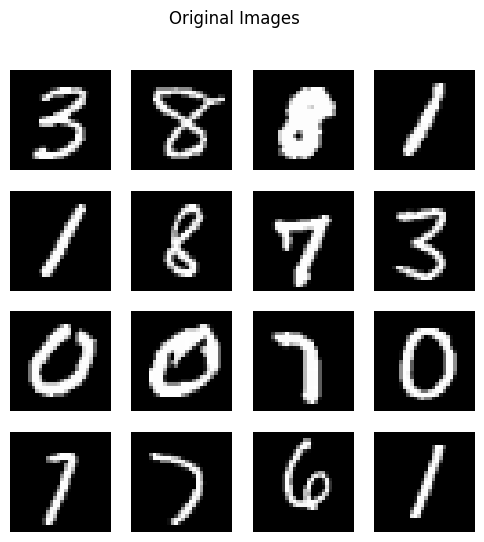

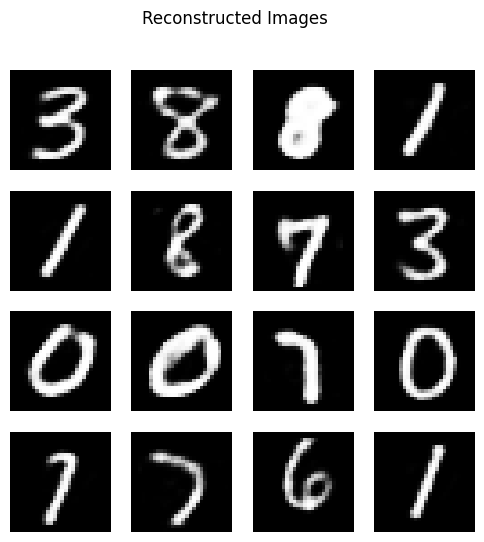

Testing Images Reconstruction:


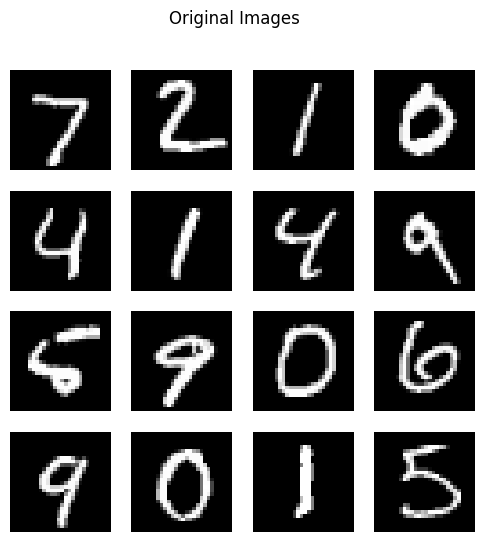

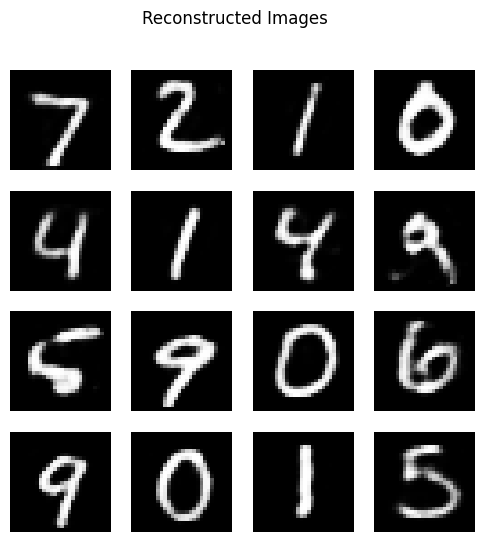


Training Autoencoder with latent dimension = 32
Epoch [1/10], Loss: 0.0437
Epoch [2/10], Loss: 0.0182
Epoch [3/10], Loss: 0.0141
Epoch [4/10], Loss: 0.0126
Epoch [5/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0110
Epoch [7/10], Loss: 0.0104
Epoch [8/10], Loss: 0.0100
Epoch [9/10], Loss: 0.0097
Epoch [10/10], Loss: 0.0094
Training MSE: 0.0091, L1 Loss: 0.0321
Testing  MSE: 0.0091, L1 Loss: 0.0317
Training Images Reconstruction:


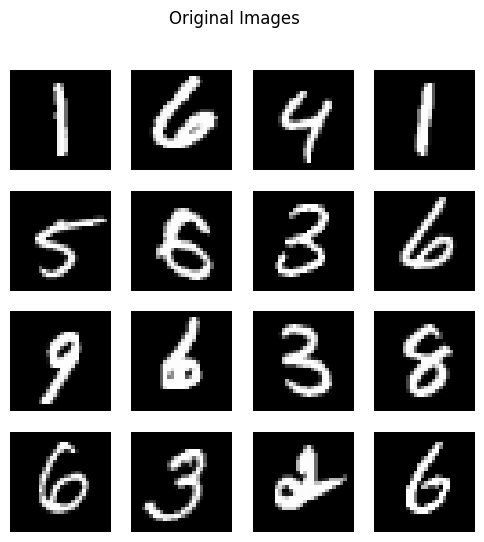

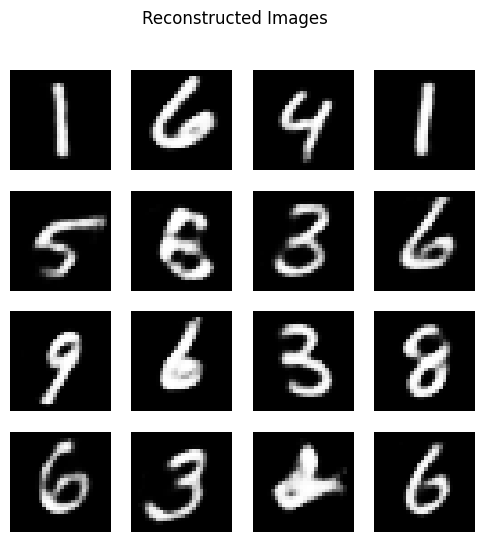

Testing Images Reconstruction:


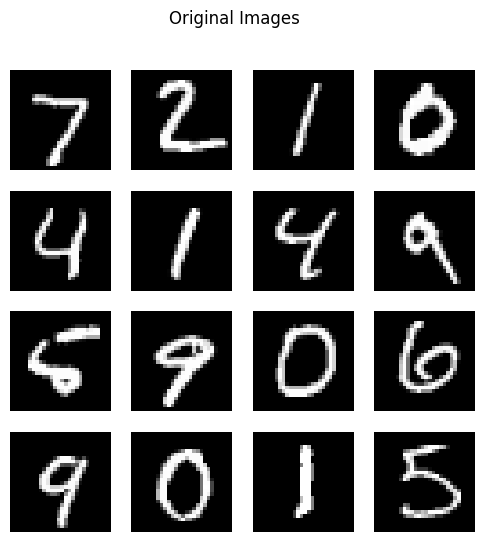

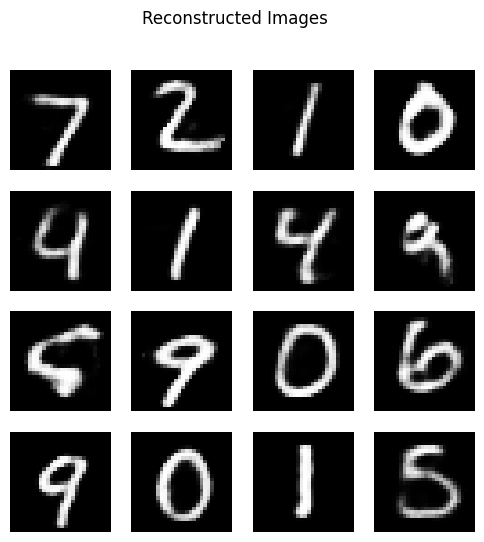


Training Autoencoder with latent dimension = 4
Epoch [1/10], Loss: 0.0606
Epoch [2/10], Loss: 0.0512
Epoch [3/10], Loss: 0.0492
Epoch [4/10], Loss: 0.0479
Epoch [5/10], Loss: 0.0469
Epoch [6/10], Loss: 0.0461
Epoch [7/10], Loss: 0.0430
Epoch [8/10], Loss: 0.0407
Epoch [9/10], Loss: 0.0397
Epoch [10/10], Loss: 0.0390
Training MSE: 0.0388, L1 Loss: 0.0924
Testing  MSE: 0.0392, L1 Loss: 0.0929
Training Images Reconstruction:


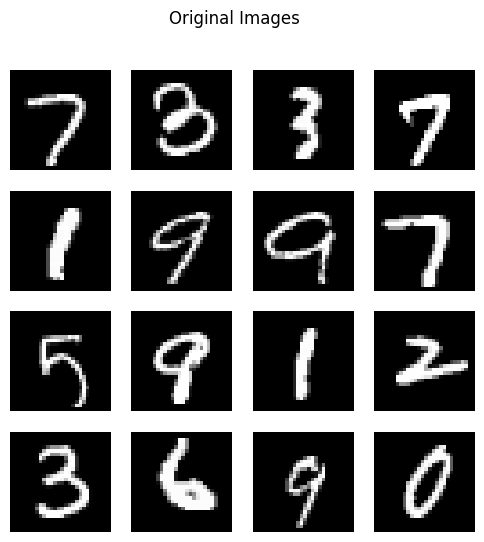

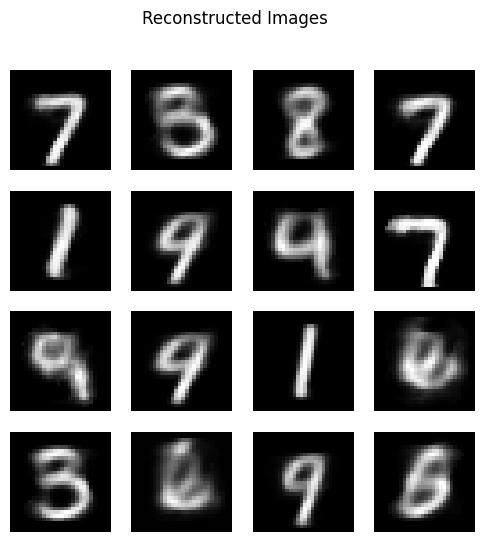

Testing Images Reconstruction:


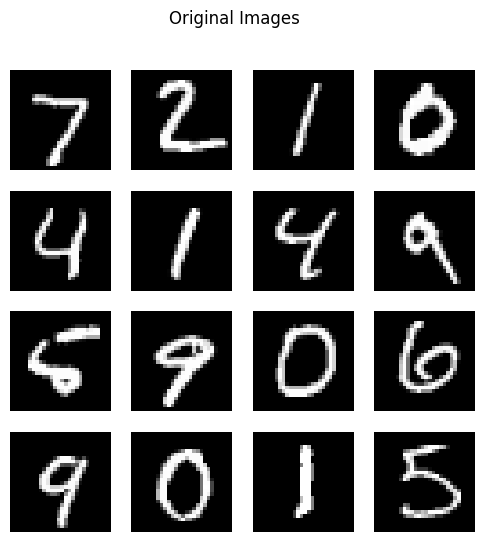

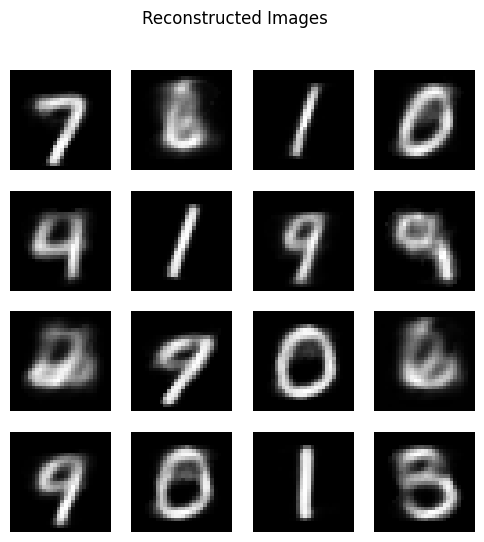

In [14]:
#  訓練並評估 Autoencoder（測試不同 latent_dim）
latent_dims = [64, 32, 4]

for latent_dim in latent_dims:
    print(f"\nTraining Autoencoder with latent dimension = {latent_dim}")
    autoencoder = Autoencoder(latent_dim)
    train_autoencoder(autoencoder, train_loader, num_epochs=10)

    train_mse, train_l1 = evaluate_autoencoder(autoencoder, train_loader)
    test_mse, test_l1 = evaluate_autoencoder(autoencoder, test_loader)

    print(f"Training MSE: {train_mse:.4f}, L1 Loss: {train_l1:.4f}")
    print(f"Testing  MSE: {test_mse:.4f}, L1 Loss: {test_l1:.4f}")

    # 顯示重建影像
    print("Training Images Reconstruction:")
    show_reconstructed_images(autoencoder, train_loader)

    print("Testing Images Reconstruction:")
    show_reconstructed_images(autoencoder, test_loader)